In [5]:
import os
import copy
import torch
from torchvision import transforms
from  torchvision.ops import box_iou
from util.augmentations import Compose
from util.data_aug import *
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torchvision
from util.utils import box_iou
from util.actions_tree import Actor
import torch.nn.functional as F
from models.mnist_scale_model import Net, Agent
from datasets.clutter_mnist_scale_rl import MNIST_CoLoc
from RL_entropy import get_policy_loss
import matplotlib.ticker as ticker

img_size = 84
num_cls = 10
batch_size = 320

os.environ['CUDA_VISIBLE_DEVICES']='3'

def convert_image_np(inp, norm=True):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    if norm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    return inp


In [6]:
def init_dataloader():
    kwargs = {'num_workers': 8, 'pin_memory': True}

    train_transform = Compose([Resize(84)])
    test_transform = Compose([Resize(84)])
    trainset = MNIST_CoLoc(root='.', train=True, digit=4,
                           datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                           clutter=1, transform=train_transform)
    testset = MNIST_CoLoc(root='.', train=False, digit=4,
                          datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                          clutter=1, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=512, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=512, shuffle=False, **kwargs)
    print('total train image: ', len(train_loader.dataset), ' test image: ',
          len(test_loader.dataset))
    return train_loader, test_loader

In [9]:
def init_model(hidden_size, freeze=1):
    net = Net(pooling_size=5,
              pooling_mode='align').to(device)
    agent = Agent(dim=512, num_class=14,
                  hidden_size=hidden_size).to(device)
    # if load pretrained encoder
    pretrained = 'cluttermnistARLarger_m60_trip_SGD_scale_anchorsmp_2fc5conv/best.pth.tar'
    ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                      'selfpaced/ordinal/',
                      pretrained))
    net.load_state_dict(ckpt['state_dict'])
    print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                ckpt['epoch'], ckpt['acc']))
    if freeze == 1:
        for name, value in net.named_parameters():
            value.requires_grad = False

    return net, agent


In [10]:
hidden_size = 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = init_dataloader()
model, agent = init_model(hidden_size=hidden_size)

# load model 
savename = 'coloc_rl_seq10_scale_ent5_joint_lr1e03_2fc5conv_ARLarger'
#savename = 'coloc_rl_seq10_scale_ent1' # 88% acc
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, savename, 'best_agent.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
best_loss = ckpt['acc']
agent.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {} {}".format(epoch, best_loss)))

total train image:  5842  test image:  982
loaded from cluttermnistARLarger_m60_trip_SGD_scale_anchorsmp_2fc5conv/best.pth.tar
ckpt epoch 36 acc 94.81%
loading ckpt from  /research/cbim/vast/tl601/results/selfpaced/ordinal/coloc_rl_seq10_scale_ent5_joint_lr1e03_2fc5conv_ARLarger/best_agent.pth.tar
=> loaded checkpoint epoch 153 79.93890380859375


t  0  probs  tensor([[5.22e-31, 7.14e-11, 1.48e-19, 1.00e+00, 2.33e-12, 4.97e-09, 2.86e-19,
         3.29e-14, 1.06e-26, 1.66e-23, 4.62e-09, 2.17e-18, 2.52e-12, 1.06e-08],
        [6.35e-05, 1.02e-03, 3.60e-02, 9.56e-01, 1.01e-04, 7.79e-04, 1.44e-06,
         2.08e-06, 5.28e-07, 3.32e-08, 7.17e-04, 2.79e-04, 1.09e-04, 5.17e-03],
        [1.95e-13, 4.60e-01, 4.34e-10, 5.40e-01, 1.99e-11, 6.10e-10, 2.98e-15,
         1.24e-13, 4.87e-18, 2.16e-21, 1.37e-10, 1.29e-10, 1.80e-15, 1.14e-09],
        [2.11e-05, 1.00e+00, 1.96e-14, 1.39e-16, 1.72e-15, 4.29e-15, 7.82e-19,
         7.97e-18, 7.70e-23, 1.18e-25, 2.22e-14, 1.36e-16, 3.29e-21, 6.77e-16],
        [1.95e-16, 1.05e-13, 1.82e-05, 1.00e+00, 3.53e-18, 8.81e-12, 6.25e-21,
         1.44e-21, 3.57e-23, 1.72e-27, 1.16e-12, 4.27e-15, 5.68e-17, 2.83e-10]],
       device='cuda:0')


/research/cbim/vast/tl601/anaconda3/envs/torch_ml/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


t  1  probs  tensor([[7.45e-15, 5.14e-06, 1.34e-15, 1.74e-09, 4.98e-03, 5.06e-01, 1.23e-12,
         5.70e-07, 3.76e-23, 1.38e-14, 4.51e-01, 2.03e-19, 1.59e-02, 2.20e-02],
        [9.98e-01, 2.50e-05, 1.30e-05, 4.44e-12, 2.05e-06, 4.46e-04, 7.37e-07,
         5.37e-07, 3.93e-10, 1.42e-09, 1.86e-04, 4.39e-10, 9.68e-04, 2.72e-05],
        [5.61e-22, 1.71e-14, 4.04e-11, 1.00e+00, 3.48e-12, 1.21e-09, 1.26e-16,
         7.17e-13, 4.65e-20, 1.18e-19, 1.23e-10, 7.91e-14, 1.15e-07, 3.25e-09],
        [9.18e-01, 2.14e-13, 8.23e-02, 8.06e-13, 1.41e-08, 4.23e-07, 6.90e-12,
         1.71e-14, 7.22e-17, 9.24e-16, 1.17e-05, 7.06e-15, 2.31e-05, 3.98e-06],
        [2.56e-07, 1.97e-24, 1.00e+00, 2.25e-13, 2.50e-16, 4.35e-11, 9.67e-16,
         1.04e-14, 4.36e-20, 2.54e-22, 1.47e-10, 4.31e-17, 3.31e-09, 3.49e-11]],
       device='cuda:0')
t  2  probs  tensor([[1.32e-18, 9.54e-08, 3.41e-14, 1.42e-06, 3.86e-02, 2.91e-01, 4.06e-13,
         2.84e-07, 5.15e-21, 1.32e-15, 3.42e-01, 1.89e-19, 1.87e-04, 3.29e-

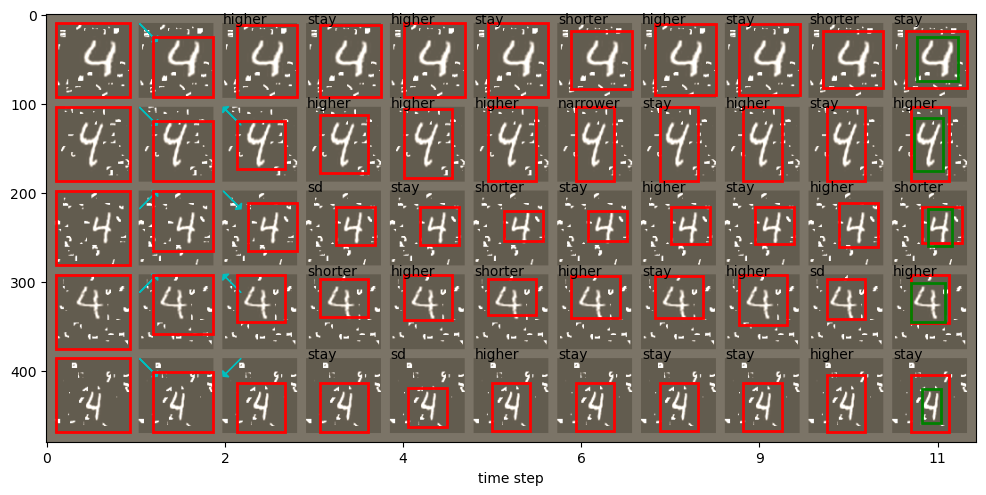

In [14]:
# visualize actions
torch.set_printoptions(precision=2, threshold=10000)
seq_len = 10
num = 5
batch_size = 512
with torch.no_grad():
    model.eval()
    agent.eval()
    data_org, target_org = next(iter(test_loader))
    data_org, target_org = data_org.to(device), target_org.to(device).float()
    data, target = data_org[:num], target_org[:num].clone()
    img = convert_image_np(torchvision.utils.make_grid(data.repeat(1, seq_len+1, 1, 1).view(num*(seq_len+1),
                                1, data.shape[2], data.shape[3]).cpu(), nrow=seq_len+1,
                                    padding=10), norm=True)

    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

    state = data_org.clone()
    all_embed = []
    logits_seq = []
    pred_boxes = torch.tensor([[0,0,83,83]]).float().repeat(batch_size, 1)
    boxes = [pred_boxes]
    rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
    org_boxes = pred_boxes.clone().to(device)
    rois_t0 = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                            target_org.to(device)), dim=1)
    action_seq = torch.IntTensor(batch_size, seq_len).to(device)
    rewards_all = torch.zeros((batch_size, seq_len+1)).to(device)
    actor = Actor(data_org, min_box_side=28)
    if hidden_size:
        h_t = torch.zeros(
            batch_size,
            hidden_size,
            dtype=torch.float,
            device=device,
            requires_grad=True,
        )
    # 1st forward classifier
    with torch.no_grad():
        embed_t = model(data_org, rois_t0)
        embed = model.get_roi_embedding(rois)
    rewards_all[:, 0] = F.pairwise_distance(embed_t, embed)

    for t in range(seq_len):
        if hidden_size:
            h_t, logits, actions, _ = agent(embed, h_t_prev=h_t)
        else:
            logits, actions, _ = agent(embed)
        print('t ', t, ' probs ', F.softmax(logits, dim=1)[:5])
#         if t == 2:
#             actions[0,0] = 13
        state, pred_boxes = actor.takeaction(actions)
        rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
        with torch.no_grad():
            embed = model.get_roi_embedding(rois)
        all_embed.append(embed)
        #rewards_all[:, t+1] = F.pairwise_distance(embed_t, embed)
        action_seq[:, t] = actions.view(1, -1)
        logits_seq.append(logits)
        boxes.append(pred_boxes)
        
    

    rewards_trns = F.pairwise_distance(embed_t.repeat(seq_len, 1),
                                       torch.cat(all_embed))
    rewards_all[:, 1:] = rewards_trns.view(-1, batch_size).permute(1,0)
    
    boxes_copy = copy.deepcopy(boxes)
    target_copy = copy.deepcopy(target)
    for t in range(len(boxes)):
        for i, b in enumerate(boxes[t][:num]): # (num ,4)
            change_y = i * (img_size+10) + 10
            change_x = t * (img_size+10) + 10
            b[1::2] += change_y # change y1, y2
            b[::2] += change_x     # 
            #print('t ', t, ' change_y ', change_y, ' change_x ', change_x)
            
            if t>0:
                if action_seq[i, t-1] == 0: #shrink towards TL
                    plt.arrow(change_x+20, change_y+20, -20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 1: #shrink towards TR
                    plt.arrow(change_x, change_y+20, 20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 2: #shrink toward bottom left
                    plt.arrow(change_x+20, change_y, -20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 3: #shrink toward bottom right 
                    plt.arrow(change_x, change_y, 20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 4: # scale down
                    plt.text(change_x, change_y, 'sd')
                elif action_seq[i,t-1] == 5: #stay 
                    plt.text(change_x, change_y, 'stay')
                elif action_seq[i,t-1] == 6: #left 
                    plt.arrow(change_x+20, change_y+3, -20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 7: # right
                    plt.arrow(change_x, change_y+3, 20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 8: # up
                    plt.arrow(change_x+3, change_y+20, 0, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 9: # down
                    plt.arrow(change_x+3, change_y, 0, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 10: # higher
                    plt.text(change_x, change_y, 'higher')
                elif action_seq[i,t-1] == 11: # wider
                    plt.text(change_x, change_y, 'wider')
                elif action_seq[i,t-1] == 12: # narrower
                    plt.text(change_x, change_y, 'narrower')
                elif action_seq[i,t-1] == 13: # shorter
                    plt.text(change_x, change_y, 'shorter')
            
    
    for i in range(target.shape[0]):
        target[i, 1::2] += i * (img_size+10) + 10
        target[i, ::2]  += seq_len * (img_size+10) + 10
    
    for box in boxes:
        for x1, y1, x2, y2 in box[:num]:
            patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='r', facecolor='none', fill=False)
            ax.add_patch(patch)
            
    for x1, y1, x2, y2 in target:
        patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='g', facecolor='none', fill=False)
        ax.add_patch(patch)
    
    ax.set_xlabel('time step')
    scale_x = img_size + 10
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    plt.show()

rewards_all  tensor([237.92, 249.00, 121.71, 138.38, 444.13], device='cuda:0')


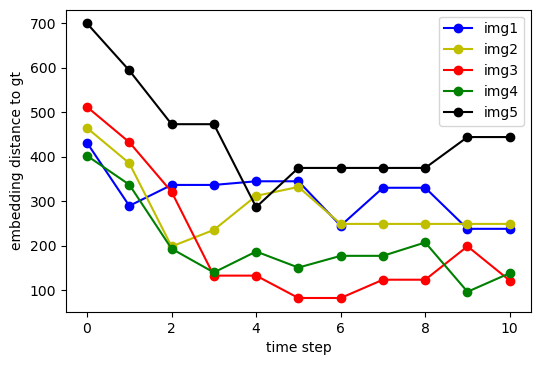

In [15]:
# plot rewards_all, i.e., distance to target
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
print('rewards_all ', rewards_all[:5, -1].view(-1))
for i, r in enumerate(rewards_all[:5].cpu().numpy()):
    plt.plot(range(seq_len+1), r, colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.xlabel('time step')
plt.ylabel('embedding distance to gt')
plt.show()

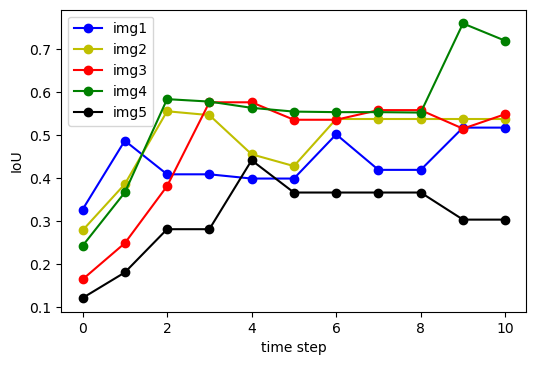

In [16]:
# plot iou
boxes_copy = torch.stack(boxes_copy).permute(1,0,2)[:5]
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
for i in range(5):
    ious = box_iou(boxes_copy[i].view(-1, 4), target_org[i].view(-1,4).cpu())
    plt.plot(range(seq_len+1), ious.view(-1).numpy(), colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.xlabel('time step')
plt.ylabel('IoU')
plt.show()